In [1]:
import sys
import pandas as pd
import numpy as np
from econml.grf import CausalForest

In [2]:
from helpers import auto_dummy

In [6]:
#del sys.modules["decompositions"]
from decompositions import fairness_cookbook

E:\PhD\01_causalfairness\00_codes\decompositions.py:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
  Z = None if ((len(Z)==0) | (Z is "")) else Z
E:\PhD\01_causalfairness\00_codes\decompositions.py:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
  W = None if ((len(W)==0) | (W is "")) else W


In [4]:
#del sys.modules["helpers"]
#from helpers import msd_one, msd_two, msd_three, inh_str, auto_dummy

In [5]:
#del sys.modules["causal_forest"]
#from causal_forest import ci_crf

- fairness cookbook

In [7]:
data_gov = pd.read_csv('gov_census.csv',index_col=0).head(20000)

In [8]:
data_gov[data_gov['sex']=="male"]['salary'].mean() - data_gov[data_gov['sex']=="female"]['salary'].mean()

15053.691747379096

In [9]:
data_gov

,sex,age,race,hispanic_origin,citizenship,nativity,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry,economic_region
1,male,64,black,no,1,native,married,2,0,20,0,43000.0,56,49,13-1081,928P,Southeast
2,female,54,white,no,1,native,married,3,1,20,0,45000.0,42,49,29-2061,6231,Southeast
3,male,38,black,no,1,native,married,3,1,24,0,99000.0,50,49,25-1000,611M1,Southeast
4,female,41,asian,no,1,native,married,3,1,24,0,63000.0,50,49,25-1000,611M1,Southeast
5,female,40,white,no,1,native,married,4,2,21,0,45200.0,40,49,27-1010,611M1,Southeast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,female,54,white,no,1,native,married,2,0,22,0,38000.0,40,39,27-3092,923,Far West
19997,male,43,other,yes,4,foreign-born,divorced,4,0,21,1,100000.0,40,49,33-3021,92MP,Far West
19998,male,35,AIAN,yes,4,foreign-born,married,4,2,22,2,73000.0,40,47,25-2030,6111,Far West
19999,male,26,white,no,1,native,married,2,0,18,0,60000.0,75,49,55-2010,928110P4,Far West


In [10]:
data = data_gov

#protected class
X = "sex"
#outcome
Y = "salary"
#confounders
Z = np.array(["age","race","hispanic_origin",
             "citizenship","nativity","economic_region"])
#mediators
W = np.array(["marital","family_size","children",
             "education_level","english_level","hours_worked"
             ,"weeks_worked","occupation","industry"])

In [11]:
np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_gov,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 10, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = True,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

In [12]:
measure_boots

,boot,value,measure,rep
0,0.0,14776.506091,tv,0.0
1,1.0,15283.279976,tv,0.0
2,2.0,15011.720158,tv,0.0
3,3.0,16193.950962,tv,0.0
4,4.0,14958.769673,tv,0.0
...,...,...,...,...
95,95.0,-817.444850,ctfie,9.0
96,96.0,-869.968308,ctfie,9.0
97,97.0,-875.879877,ctfie,9.0
98,98.0,-805.973464,ctfie,9.0


In [14]:
measure_summary

value            
                  mean         std
measure                           
ctfde     14863.775337  371.561427
ctfie      -571.216853  200.778696
ctfse       625.882690  658.544082
ett       15434.992189  449.500517
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       14811.643626  380.281336
nie        -343.169965  169.246536
te        15154.813591  412.944184
tv        14809.109499  723.157766

# Base model tests

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [77]:
data_gov = pd.read_csv('gov_census.csv',index_col=0)

In [78]:
# mannually creat dummies
data_gov_dum, Z = auto_dummy(data = data_gov, col = Z)
data_gov_dum, W = auto_dummy(data = data_gov_dum, col = W)

data_gov_dum[X] = np.where(data_gov_dum[X]=="female",0,1)

In [79]:
feat_mat = data_gov_dum[np.concatenate([np.array(X).reshape(-1),Z,W])]
y_mat = data_gov_dum[Y]

In [82]:
feat_mat_train, feat_mat_test, y_mat_train, y_mat_test = train_test_split(feat_mat, y_mat, test_size=0.10, random_state=2023)

<Axes: ylabel='Frequency'>

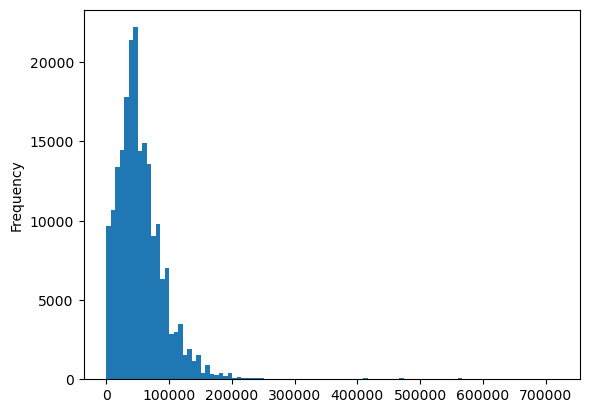

In [120]:
y_mat.plot.hist(bins=100)

In [165]:
np.mean(y_mat),np.median(y_mat),np.std(y_mat)

(55774.63214053223, 50000.0, 42563.72465870298)

- OLS

In [123]:
lr = LinearRegression()
lr.fit(feat_mat_train, y_mat_train)
y_pred_test_lr = lr.predict(feat_mat_test)

In [124]:
#performance on the regular linear regression
print("rmse: ", mean_squared_error(y_mat_test, y_pred_test_lr, squared=False),";mae: ", mean_absolute_error(y_mat_test, y_pred_test_lr), " ;r2: ", r2_score(y_mat_test, y_pred_test_lr))

rmse:  2658884368174.774 ;mae:  28749136843.701763  ;r2:  -4008942108040284.5


- decision tree

In [97]:
dt = DecisionTreeRegressor()
dt.fit(feat_mat_train, y_mat_train)
y_pred_test_dt = dt.predict(feat_mat_test)

In [100]:
#performance on the regular decision tree regression
print("rmse: ", mean_squared_error(y_mat_test, y_pred_test_dt, squared=False),";mae: ", mean_absolute_error(y_mat_test, y_pred_test_dt), " ;r2: ", r2_score(y_mat_test, y_pred_test_dt))

rmse:  42187.085941924284 ;mae:  22984.377768045237  ;r2:  -0.009229504724325377


- random forest

In [114]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(feat_mat_train, y_mat_train)
y_pred_test_rf = rf.predict(feat_mat_test)

In [115]:
#performance on the regular decision tree regression
print("rmse: ", mean_squared_error(y_mat_test, y_pred_test_rf, squared=False),";mae: ", mean_absolute_error(y_mat_test, y_pred_test_rf), " ;r2: ", r2_score(y_mat_test, y_pred_test_rf))

rmse:  31263.839337496247 ;mae:  17720.224748434517  ;r2:  0.445737490576133


- xgb

In [106]:
xgb = XGBRegressor(n_jobs=-1)
xgb.fit(feat_mat_train, y_mat_train)
y_pred_test_xgb = xgb.predict(feat_mat_test)

In [107]:
#performance on the regular decision tree regression
print("rmse: ", mean_squared_error(y_mat_test, y_pred_test_xgb, squared=False),";mae: ", mean_absolute_error(y_mat_test, y_pred_test_xgb), " ;r2: ", r2_score(y_mat_test, y_pred_test_xgb))

rmse:  29550.907672524703 ;mae:  17190.215518865785  ;r2:  0.5048092389926389


- mlp

In [110]:
mlp = MLPRegressor()
mlp.fit(feat_mat_train, y_mat_train)
y_pred_test_mlp = mlp.predict(feat_mat_test)

E:\Anaconda\envs\causalfairness\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [111]:
#performance on the regular decision tree regression
print("rmse: ", mean_squared_error(y_mat_test, y_pred_test_mlp, squared=False),";mae: ", mean_absolute_error(y_mat_test, y_pred_test_mlp), " ;r2: ", r2_score(y_mat_test, y_pred_test_mlp))

rmse:  30829.331716478482 ;mae:  18695.4918599849  ;r2:  0.46103681031081933


- check causal effects in the test set

In [158]:
#original label
#original label
data_orig = feat_mat_test.reset_index(drop=True)
data_orig['salary'] = y_mat_test.values
data_orig[X] = np.where(data_orig[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_orig,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value            
                  mean         std
measure                           
ctfde     14503.852342  621.472760
ctfie      -751.041039  150.512115
ctfse       784.919031  618.039240
ett       15254.893381  626.732175
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       14460.211876  647.547318
nie        -533.602594  126.058896
te        14993.814469  620.992390
tv        14469.974351  889.864660

In [159]:
#lr prediction
data_lr = feat_mat_test.reset_index(drop=True)
data_lr['salary'] = y_pred_test_lr
data_lr[X] = np.where(data_lr[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_lr,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value              
                  mean           std
measure                             
ctfde    -5.855768e+10  3.549104e+10
ctfie    -6.852354e+08  8.077657e+09
ctfse     1.107390e+09  3.625115e+10
ett      -5.787245e+10  3.575808e+10
expse_x0           NaN           NaN
expse_x1           NaN           NaN
nde      -5.887120e+10  3.536316e+10
nie      -1.534344e+09  8.654527e+09
te       -5.733686e+10  3.401082e+10
tv       -5.897984e+10  5.141749e+10

In [160]:
#decision tree prediction
data_dt = feat_mat_test.reset_index(drop=True)
data_dt['salary'] = y_pred_test_dt
data_dt[X] = np.where(data_dt[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_dt,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value            
                  mean         std
measure                           
ctfde     13105.515524  601.342461
ctfie      -771.021726  165.559260
ctfse       808.296906  632.776938
ett       13876.537250  620.953633
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       13038.523102  628.854070
nie        -539.533770  119.079784
te        13578.056873  611.267984
tv        13068.240343  867.315398

In [161]:
#random forest prediction
data_rf = feat_mat_test.reset_index(drop=True)
data_rf['salary'] = y_pred_test_rf
data_rf[X] = np.where(data_rf[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_rf,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value            
                  mean         std
measure                           
ctfde     13671.494717  519.385329
ctfie      -860.525196  147.855291
ctfse       894.877099  484.511116
ett       14532.019913  543.840991
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       13609.592106  541.574674
nie        -631.444451  119.028977
te        14241.036557  535.955937
tv        13637.142814  704.038686

In [162]:
#xgboost prediction
data_xgb = feat_mat_test.reset_index(drop=True)
data_xgb['salary'] = y_pred_test_xgb
data_xgb[X] = np.where(data_xgb[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_xgb,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value            
                  mean         std
measure                           
ctfde     14587.982205  429.940110
ctfie      -847.538402  126.830229
ctfse       921.147405  446.913824
ett       15435.520607  440.988411
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       14492.631522  438.453492
nie        -628.057088  111.853665
te        15120.688611  440.762570
tv        14514.373202  607.427771

In [163]:
#mlp prediction
data_mlp = feat_mat_test.reset_index(drop=True)
data_mlp['salary'] = y_pred_test_mlp
data_mlp[X] = np.where(data_mlp[X]==0,"female",'male')

np.random.seed(seed=2023)
measure_boots, measure_summary = fairness_cookbook(data = data_mlp,
                                  X=X,
                                  Z=Z,
                                  W=W, 
                                  Y=Y, 
                                  x0="female",
                                  x1="male",
                                  method = "causal_forest", 
                                  nboot1 = 30, 
                                  nboot2 = 100,
                                  if_auto_dummy = True,
                                  crf_n_estimators = 100, 
                                  crf_criterion = "het", 
                                  crf_min_samples_leaf = 5, 
                                  crf_max_features = "sqrt", 
                                  crf_honest = False,
                                  crf_max_samples = 0.5,
                                  crf_min_samples_split=2, 
                                  crf_min_balancedness_tol=0.45, 
                                  crf_inference=False)

measure_summary

value            
                  mean         std
measure                           
ctfde     14430.926065  409.574597
ctfie      -742.049955  119.469791
ctfse       842.269203  420.135560
ett       15172.976020  398.167014
expse_x0           NaN         NaN
expse_x1           NaN         NaN
nde       14302.174021  408.045410
nie        -626.003519  111.419081
te        14928.177540  396.768192
tv        14330.706817  571.924290

# Test of helpers

- ci_helper

In [8]:
data_adj, Z_adj = auto_dummy(data=data_gov.head(10),col=Z)

In [9]:
data_adj

,race_asian,race_black,race_white,hispanic_origin_no,nativity_native,economic_region_Southeast,age,citizenship,sex,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry
1,0,1,0,1,1,1,64,1,male,married,2,0,20,0,43000.0,56,49,13-1081,928P
2,0,0,1,1,1,1,54,1,female,married,3,1,20,0,45000.0,42,49,29-2061,6231
3,0,1,0,1,1,1,38,1,male,married,3,1,24,0,99000.0,50,49,25-1000,611M1
4,1,0,0,1,1,1,41,1,female,married,3,1,24,0,63000.0,50,49,25-1000,611M1
5,0,0,1,1,1,1,40,1,female,married,4,2,21,0,45200.0,40,49,27-1010,611M1
6,0,0,1,1,1,1,46,1,female,divorced,3,1,18,0,28000.0,40,49,43-6014,6111
7,0,0,1,1,1,1,41,1,male,married,4,2,21,0,58000.0,45,49,13-1070,611M1
8,0,0,1,1,1,1,54,1,male,married,2,0,19,0,65000.0,55,49,33-3050,92MP
9,0,0,1,1,1,1,29,1,male,married,2,0,18,0,32000.0,40,49,33-3050,92MP
10,0,0,1,1,1,1,43,1,female,married,2,0,18,0,6000.0,16,26,43-5031,92MP


In [10]:
Z_adj

array(['race_asian', 'race_black', 'race_white', 'hispanic_origin_no',
       'nativity_native', 'economic_region_Southeast', 'age',
       'citizenship'], dtype=object)

In [9]:
y = np.arange(0,10)

In [10]:
boots = {1:{'all':np.arange(0,10),'id0':[0,1,2],'id1':[3,4,5,6,7,8,9]},
         2:{'all':np.array([0,1,1,2,3,5,6,7,4,9]),'id0':[0,1,1,2],'id1':[3,5,6,7,4,9]}}

In [5]:
pd.DataFrame({'boot':[],
             'value':[],
             'measure':[],
             'rep':[]})

,boot,value,measure,rep


In [11]:
msd_one(y,"id0","te",boots)

,boot,value,measure
0,0,1.0,te
1,1,1.0,te


In [12]:
msd_two(y,"id0",-y,"id1","te",boots)

,boot,value,measure
0,0,-5.000000,te
1,1,-4.666667,te


In [13]:
np.mean([0,1,2])-np.mean([3,4,5,6,7,8,9])

-5.0

In [14]:
np.mean([0,1,1,2])-np.mean([3,5,6,7,4,9])

-4.666666666666667

In [15]:
msd_three(y,"id0",-y,"id1",y,"id1","te",boots)

,boot,value,measure
0,0,1.0,te
1,1,1.0,te


In [16]:
df_cihelpher = msd_three(y,"id0",-y,"id1",y,"id1","te",boots)

In [17]:
df_cihelpher

,boot,value,measure
0,0,1.0,te
1,1,1.0,te


In [18]:
inh_str(df_cihelpher,"ctfde",set0=True)

,boot,value,measure
0,0,0,ctfde
1,1,0,ctfde


In [19]:
inh_str(df_cihelpher,"ctfde",set0=True,setna=True)

,boot,value,measure
0,0,NaN,ctfde
1,1,NaN,ctfde


- causal forest

In [20]:
test = 1 if False else 2

In [21]:
test

2

In [22]:
np.random.randint(0,df_cihelpher.shape[0],df_cihelpher.shape[0])

array([1, 1])

In [23]:
df_cihelpher.shape[0]

2

In [24]:
np.arange(0,df_cihelpher.shape[0])

array([0, 1])

In [25]:
data_gov_head = data_gov.head(10)

In [26]:
data = data_gov_head
nrow_df = data.shape[0]
print(data.shape[0])
rep = 1
nboot = 5
x0="female"
X = "sex"

boot_samp = np.random.randint(0,nrow_df,nrow_df) if rep>1 else np.arange(0,nrow_df)  
boot_data = data.iloc[boot_samp,:].reset_index(drop=True)

nrow_boot_df = boot_data.shape[0]
boots = dict.fromkeys(np.arange(nboot))
for key in boots:
    boots[key] = dict.fromkeys(["all","id0","id1"])
    ind = np.random.randint(0,nrow_boot_df,nrow_boot_df)

    idx0 = boot_data[X][ind] == x0
    ind0 = ind[idx0]
    ind1 = ind[~idx0]

    boots[key]["all"] = ind
    boots[key]["id0"] = ind0
    boots[key]["id1"] = ind1

10


In [27]:
boot_data[X][ind]

6      male
7      male
5    female
1    female
2      male
8      male
5    female
7      male
9    female
7      male
Name: sex, dtype: object

In [28]:
boots

{0: {'all': array([9, 4, 6, 9, 9, 5, 4, 4, 3, 9]),
  'id0': array([9, 4, 9, 9, 5, 4, 4, 3, 9]),
  'id1': array([6])},
 1: {'all': array([3, 5, 7, 4, 6, 1, 7, 6, 7, 1]),
  'id0': array([3, 5, 4, 1, 1]),
  'id1': array([7, 6, 7, 6, 7])},
 2: {'all': array([1, 6, 1, 1, 2, 5, 8, 1, 0, 3]),
  'id0': array([1, 1, 1, 5, 1, 3]),
  'id1': array([6, 2, 8, 0])},
 3: {'all': array([8, 1, 0, 6, 9, 5, 3, 0, 6, 3]),
  'id0': array([1, 9, 5, 3, 3]),
  'id1': array([8, 0, 6, 0, 6])},
 4: {'all': array([6, 7, 5, 1, 2, 8, 5, 7, 9, 7]),
  'id0': array([5, 1, 5, 9]),
  'id1': array([6, 7, 2, 8, 7, 7])}}

In [29]:
Y = "salary"

In [30]:
y = boot_data[Y].astype(float)

In [31]:
tv = msd_two(y, "id1", -y, "id0", "tv", boots)    

In [32]:
tv

,boot,value,measure
0,0,30155.555556,tv
1,1,16960.000000,tv
2,2,12833.333333,tv
3,3,5800.000000,tv
4,4,37250.000000,tv


In [33]:
[1]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [37]:
np.array([tv['value'][0]]*data.shape[0])

array([30155.55555556, 30155.55555556, 30155.55555556, 30155.55555556,
       30155.55555556, 30155.55555556, 30155.55555556, 30155.55555556,
       30155.55555556, 30155.55555556])

In [39]:
boot_data[Y].astype(float).values

array([43000., 45000., 99000., 63000., 45200., 28000., 58000., 65000.,
       32000.,  6000.])

In [40]:
data_gov_head

,sex,age,race,hispanic_origin,citizenship,nativity,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry,economic_region
1,male,64,black,no,1,native,married,2,0,20,0,43000.0,56,49,13-1081,928P,Southeast
2,female,54,white,no,1,native,married,3,1,20,0,45000.0,42,49,29-2061,6231,Southeast
3,male,38,black,no,1,native,married,3,1,24,0,99000.0,50,49,25-1000,611M1,Southeast
4,female,41,asian,no,1,native,married,3,1,24,0,63000.0,50,49,25-1000,611M1,Southeast
5,female,40,white,no,1,native,married,4,2,21,0,45200.0,40,49,27-1010,611M1,Southeast
6,female,46,white,no,1,native,divorced,3,1,18,0,28000.0,40,49,43-6014,6111,Southeast
7,male,41,white,no,1,native,married,4,2,21,0,58000.0,45,49,13-1070,611M1,Southeast
8,male,54,white,no,1,native,married,2,0,19,0,65000.0,55,49,33-3050,92MP,Southeast
9,male,29,white,no,1,native,married,2,0,18,0,32000.0,40,49,33-3050,92MP,Southeast
10,female,43,white,no,1,native,married,2,0,18,0,6000.0,16,26,43-5031,92MP,Southeast


In [45]:
from sklearn import preprocessing

In [47]:
x0

'female'

In [48]:
np.where(boot_data["sex"]==x0,0,1)

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [44]:
boot_data["sex"]

1       male
2     female
3       male
4     female
5     female
6     female
7       male
8       male
9       male
10    female
Name: sex, dtype: object

In [50]:
boot_data = data_gov_head
crf_tmp = CausalForest()
crf_tmp.fit(X = boot_data[['citizenship']].values, T = np.where(boot_data['sex'].values==x0,0,1), y = y.values)
crf_te = crf_tmp.oob_predict( boot_data[['citizenship']].values)

In [55]:
crf_te.ravel()

array([25161.23876124, 31228.69458128, 12567.4796748 , 28800.        ,
       24065.62847608, 25806.25814863, 23315.70391872, 26654.65201465,
       32585.39371685, 19791.66666667])

In [56]:
crf_te

array([[25161.23876124],
       [31228.69458128],
       [12567.4796748 ],
       [28800.        ],
       [24065.62847608],
       [25806.25814863],
       [23315.70391872],
       [26654.65201465],
       [32585.39371685],
       [19791.66666667]])

In [58]:
np.concatenate([[0],["1"]])

array(['0', '1'], dtype='<U11')

In [59]:
data_gov_head

,sex,age,race,hispanic_origin,citizenship,nativity,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry,economic_region
1,male,64,black,no,1,native,married,2,0,20,0,43000.0,56,49,13-1081,928P,Southeast
2,female,54,white,no,1,native,married,3,1,20,0,45000.0,42,49,29-2061,6231,Southeast
3,male,38,black,no,1,native,married,3,1,24,0,99000.0,50,49,25-1000,611M1,Southeast
4,female,41,asian,no,1,native,married,3,1,24,0,63000.0,50,49,25-1000,611M1,Southeast
5,female,40,white,no,1,native,married,4,2,21,0,45200.0,40,49,27-1010,611M1,Southeast
6,female,46,white,no,1,native,divorced,3,1,18,0,28000.0,40,49,43-6014,6111,Southeast
7,male,41,white,no,1,native,married,4,2,21,0,58000.0,45,49,13-1070,611M1,Southeast
8,male,54,white,no,1,native,married,2,0,19,0,65000.0,55,49,33-3050,92MP,Southeast
9,male,29,white,no,1,native,married,2,0,18,0,32000.0,40,49,33-3050,92MP,Southeast
10,female,43,white,no,1,native,married,2,0,18,0,6000.0,16,26,43-5031,92MP,Southeast


In [62]:
pd.concat([data_gov_head,data_gov_head,data_gov_head,data_gov_head])

,sex,age,race,hispanic_origin,citizenship,nativity,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry,economic_region
1,male,64,black,no,1,native,married,2,0,20,0,43000.0,56,49,13-1081,928P,Southeast
2,female,54,white,no,1,native,married,3,1,20,0,45000.0,42,49,29-2061,6231,Southeast
3,male,38,black,no,1,native,married,3,1,24,0,99000.0,50,49,25-1000,611M1,Southeast
4,female,41,asian,no,1,native,married,3,1,24,0,63000.0,50,49,25-1000,611M1,Southeast
5,female,40,white,no,1,native,married,4,2,21,0,45200.0,40,49,27-1010,611M1,Southeast
6,female,46,white,no,1,native,divorced,3,1,18,0,28000.0,40,49,43-6014,6111,Southeast
7,male,41,white,no,1,native,married,4,2,21,0,58000.0,45,49,13-1070,611M1,Southeast
8,male,54,white,no,1,native,married,2,0,19,0,65000.0,55,49,33-3050,92MP,Southeast
9,male,29,white,no,1,native,married,2,0,18,0,32000.0,40,49,33-3050,92MP,Southeast
10,female,43,white,no,1,native,married,2,0,18,0,6000.0,16,26,43-5031,92MP,Southeast
